# MVD 12. cvičení


In [1]:
import plotly.express as px
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs

def show_figure(df, color='class'):
    fig = px.scatter(df, x="x", y="y", color=color)
    fig.show()
    

cords, labels = make_blobs(n_samples=500, cluster_std=1, centers=[(1,1)], n_features=2, random_state=42)

df1 = pd.DataFrame(cords, columns=['x', 'y'])
df1['class'] = 'TODO'
show_figure(df1)

## 1. část - Detekce anomálií pomocí Gaussova rozdělení

Detekujte anomálie ve vytvořených datech (`df1`) pomocí Gaussova (normálního) rozdělení. Implementujte jak normální rozdělení, tak vícerozměrné normální rozdělení. (viz přednáška)

In [2]:
def gauss_normal_distr_anomaly_detection(df: pd.DataFrame, eps: float = 0.001):
    data = np.array(df[['x', 'y']])
    dims_means = np.mean(data, axis=0)
    dims_vars = np.var(data, axis=0)

    # calculate signs: for each data instace
    p = lambda x, mu, sigma2: 1 / (np.sqrt(2 * np.pi * sigma2)) * np.exp(-1 * (x - mu)**2 / (2 * sigma2))  # func for computing probability

    labels = []  # labels or classes for data
    # per data sample:
    for x in data:
        px = np.array([])
        # count probability of every dimenzion value
        for j in range(x.shape[0]):
            px = np.append(px, p(x[j], dims_means[j], dims_vars[j]))
        # get a product of dimenzions probabilities
        prob_x = np.prod(px)

        # set a label for data instance based on probability: 1 - anomaly, 0 - ok
        label = '1' if prob_x < eps else '0' 
        labels.append(label)
    
    df['class'] = labels
    

In [3]:
gauss_normal_distr_anomaly_detection(df=df1, eps=0.001)
show_figure(df1)

In [4]:
def gauss_normal_distr_anomaly_detection_multidim(df: pd.DataFrame, eps: float = 0.001):
    data = np.array(df[['x', 'y']])
    m, n = data.shape

    if m <= n:
        raise ValueError("")

    dims_means = np.mean(data, axis=0)
    cov_matrix = np.cov(data.T)

    # calculate probability for one data sample (for all dims) using vectors
    p = lambda x, mu, E: 1 / (np.sqrt((2 * np.pi)**n * np.linalg.det(E))) * np.exp(-1/2 * (x - mu).T @ np.linalg.inv(E) @ (x - mu))

    labels = []
    # per data sample:
    for x in data:
        # calculate prob
        prob = p(x, dims_means, cov_matrix)
        # set label based on prob: 1 for anomaly, 0 for not
        label = '1' if prob < eps else '0'
        labels.append(label)

    df['class'] = labels

    

In [13]:
gauss_normal_distr_anomaly_detection_multidim(df=df1, eps=0.01)
show_figure(df1)

## 2. Část - Detekce anomálií pomocí sklearn knihovny

Stáhněte si [NAB Kaggle dataset](https://www.kaggle.com/boltzmannbrain/nab), který obsahuje časové řady. Vyberte si jedno CSV a zobrazte jeho průběh v grafu. Ideálně používejte knihovnu pandas.

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Artifically-generated data with varying types of anomalies.
csv_file = 'art_daily_jumpsdown.csv'
df = pd.read_csv(csv_file)
df[df.columns[0]] = pd.to_datetime(df[df.columns[0]])
df.head()

,timestamp,value
0,2014-04-01 00:00:00,18.090486
1,2014-04-01 00:05:00,20.359843
2,2014-04-01 00:10:00,21.105470
3,2014-04-01 00:15:00,21.151585
4,2014-04-01 00:20:00,18.137141


In [7]:
fig = px.line(df, x=df.columns[0], y=df.columns[1], 
              title=csv_file, 
              labels={df.columns[0]: "time", df.columns[1]: "value"})
fig.show()

Transformujte datetime do několika položek -> rok, měsíc, den, ...

In [15]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df.head()

,timestamp,value,year,month,day
0,2014-04-01 00:00:00,18.090486,2014,4,1
1,2014-04-01 00:05:00,20.359843,2014,4,1
2,2014-04-01 00:10:00,21.105470,2014,4,1
3,2014-04-01 00:15:00,21.151585,2014,4,1
4,2014-04-01 00:20:00,18.137141,2014,4,1


Prozkoumejte možnost detekce anomálií pomocí [sklearn](https://scikit-learn.org/stable/modules/outlier_detection.html) a aplikujte některou z implementovaných metod. Poté zobrazte výsledný graf včetně zvýrazněných anomálií.

In [18]:
X = df[['value']]
model = IsolationForest(contamination=0.02, random_state=42)
model.fit(X)
df['anomaly'] = model.predict(X)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

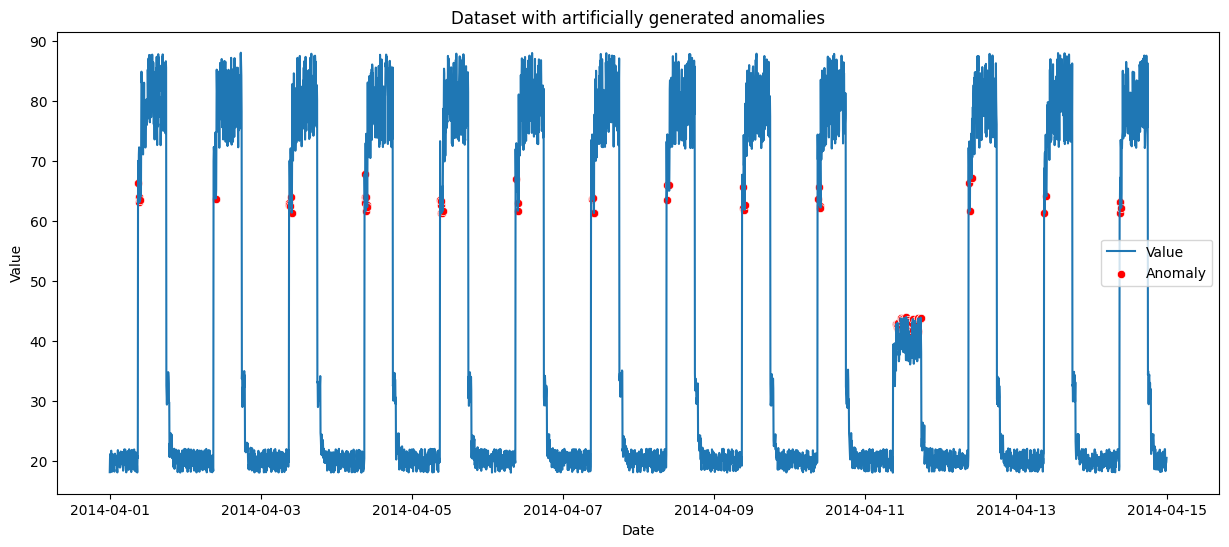

In [22]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='timestamp', y='value', label='Value')
sns.scatterplot(data=df[df['anomaly'] == 1], x='timestamp', y='value', color='red', label='Anomaly')

plt.title('Dataset with artificially generated anomalies')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

## Bonus - Implementace Local Outlier Factor algoritmu
Použijte data z [sklearn příkladu](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html). Proveďte vlastní implementaci LOF algoritmu a porovnejte výsledek s sklearn.